## Description of problem
Generate images in the style of Monet. This generator is trained using a discriminator.The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

My task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

I will utilize the tensorflow library and utlizie their documentations such as tutorial for implementing CycleGans to Horses images and other code documentations



### Kaggle Evaluation -> MiFID
Submissions are evaluated on MiFID (Memorization-informed Fréchet Inception Distance), which is a modification from Fréchet Inception Distance (FID).

The smaller MiFID is, the better the generated images is.



In [1]:
!pip install --upgrade pip
!pip install tensorflow_addons
!pip install optree


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.9 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.9 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import tensorflow_addons as tfa
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

2024-04-16 21:47:43.643030: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 21:47:43.643166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 21:47:43.769881: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of replicas: 1
2.15.0


In [3]:
gcs_path = KaggleDatasets().get_gcs_path()
gcs_path


'gs://kds-2bac02b6442f28e163ec4b67d2b23cb1b494b84653d5e7d71f1a55c8'

In [4]:
monet_filenames = tf.io.gfile.glob(str(gcs_path + '/monet_tfrec/*.tfrec'))
print(monet_filenames)

photo_filenames = tf.io.gfile.glob(str(gcs_path + '/photo_tfrec/*.tfrec'))
print(photo_filenames)

print("Length of Monet files:" ,len(monet_filenames))
print("Length of photos: ",len(photo_filenames))

['gs://kds-2bac02b6442f28e163ec4b67d2b23cb1b494b84653d5e7d71f1a55c8/monet_tfrec/monet00-60.tfrec', 'gs://kds-2bac02b6442f28e163ec4b67d2b23cb1b494b84653d5e7d71f1a55c8/monet_tfrec/monet04-60.tfrec', 'gs://kds-2bac02b6442f28e163ec4b67d2b23cb1b494b84653d5e7d71f1a55c8/monet_tfrec/monet08-60.tfrec', 'gs://kds-2bac02b6442f28e163ec4b67d2b23cb1b494b84653d5e7d71f1a55c8/monet_tfrec/monet12-60.tfrec', 'gs://kds-2bac02b6442f28e163ec4b67d2b23cb1b494b84653d5e7d71f1a55c8/monet_tfrec/monet16-60.tfrec']
['gs://kds-2bac02b6442f28e163ec4b67d2b23cb1b494b84653d5e7d71f1a55c8/photo_tfrec/photo00-352.tfrec', 'gs://kds-2bac02b6442f28e163ec4b67d2b23cb1b494b84653d5e7d71f1a55c8/photo_tfrec/photo01-352.tfrec', 'gs://kds-2bac02b6442f28e163ec4b67d2b23cb1b494b84653d5e7d71f1a55c8/photo_tfrec/photo02-352.tfrec', 'gs://kds-2bac02b6442f28e163ec4b67d2b23cb1b494b84653d5e7d71f1a55c8/photo_tfrec/photo03-352.tfrec', 'gs://kds-2bac02b6442f28e163ec4b67d2b23cb1b494b84653d5e7d71f1a55c8/photo_tfrec/photo04-352.tfrec', 'gs://kds-2ba

## Data Description
The monet directories contain Monet paintings. I use these images to train my model.

The photo directories contain photos. Add Monet-style to these images and submit your generated jpeg images as a zip file

Files:
- monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
- monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
- photo_jpg - 7028 photos sized 256x256 in JPEG format
- photo_tfrec - 7028 photos sized 256x256 in TFRecord format

In [5]:
image_size = [256, 256]
#HELPER FUNCTIONS FROM - AMY JANG "Monet CycleGAN Tutorial"
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*image_size, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

# EDA

size to 256x256. 
As these images are RGB images, set the channel to 3. 
Additionally, we need to scale the images to a [-1, 1] scale



In [6]:
monet_datasets = load_dataset(monet_filenames, labeled=True).batch(1)
photo_datasets = load_dataset(photo_filenames, labeled=True).batch(1)

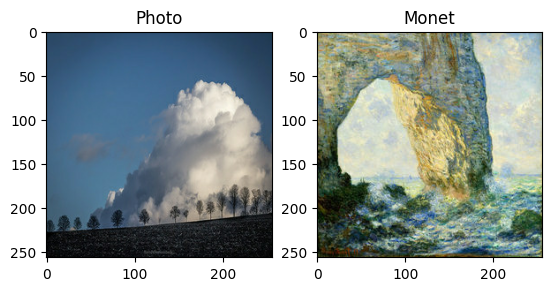

In [7]:
example_monet = next(iter(monet_datasets))
example_photo = next(iter(photo_datasets))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

# Model & Analysis (model building and training) 
- To design the cycleGAN I need to construct two generators:
    - upsampling : filters 2d dims by a defined stride
    - downsampling: increases 2d dims by a defined stride
- "The generator first downsamples the input image and then upsample while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion" - Amy Jang

Model Parameters
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
EPOCHS = 50
BATCH_SIZE = 1


In [8]:
#Helper Functions for upsampling and downsampling - Amy Jang Notebook linked below


def upsampling(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(tf.keras.layers.LayerNormalization(axis=[1, 2], center=True, scale=True, gamma_initializer=gamma_init))
#     result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tf.keras.layers.LayerNormalization(axis=[1, 2], center=True, scale=True, gamma_initializer=gamma_init))
#         result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

# Monet Generator and Monet Discriminator 

In [9]:
# Create Generator
def Monet_Generator():
    # Images are 256 X 256 and RGB = 3 Channels
    inputs = layers.Input([256,256,3])
    
    # Applying downsample to batch size and specifying filters and for each 
    downsample_stack = [
        downsample(64,4, apply_instancenorm=False),
        downsample(128,4),
        downsample(256,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4)]
    # Applying upsampling to batch size and specifying filters and for each (Reverse of downsampling)
    upsampling_stack = [
        upsampling(512,4, apply_dropout=True),
        upsampling(512,4, apply_dropout=True),
        upsampling(512,4, apply_dropout=True),
        upsampling(512,4),
        upsampling(256,4),
        upsampling(128,4),
        upsampling(64,4)]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    #output_channels = 3
    transposed_layer = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)
    #Inputs 
    x = inputs
    
    skips = []
    #Downsample through model
    for downS in downsample_stack:
        x = downS(x)
        skips.append(x)
    
    #reverse for upsampling
    skips = reversed(skips[:-1])
    
    #upsampling input
    for upS, skip in zip(upsampling_stack, skips):
        x = upS(x)
        x = layers.Concatenate()([x,skip])
        
    x = transposed_layer(x)
    
    return keras.Model(inputs=inputs, outputs=x)

In [10]:
# Discriminator
def Monet_Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.2)
    
    input_lay = layers.Input(shape=[256,256,3], name='input_image')
    
    x = input_lay
    
    downsample_1 = downsample(64,4,False)(x)
    downsample_2 = downsample(64,4,False)(downsample_1)
    downsample_3 = downsample(64,4,False)(downsample_2)
    
    #Paddings
    zero_padding_layer = layers.ZeroPadding2D()(downsample_3)    
    #Convolution
    convolution_layer = layers.Conv2D(512, 4, strides=1, kernel_initializer = initializer, use_bias=False)(zero_padding_layer)
    
    #Normalizer
    normal_layer_1 = tf.keras.layers.LayerNormalization(axis=[1, 2], center=True, scale=True, gamma_initializer=gamma_init)(convolution_layer)

    #Leaky Relu
    
    leaky_Relu_layer = layers.LeakyReLU()(normal_layer_1)
    #Another Padding Layer
    zero_padding_2 = layers.ZeroPadding2D()(leaky_Relu_layer)
    
    final_layer = layers.Conv2D(1, 4, strides=1, kernel_initializer = initializer)(zero_padding_2)
    
    return tf.keras.Model(inputs=input_lay, outputs= final_layer)

In [12]:
with strategy.scope():
    Monet_gen = Monet_Generator()
    Photo_gen = Monet_Generator()
    
    Monet_discriminator = Monet_Discriminator()
    Photo_discriminator = Monet_Discriminator()

# CycleGAN Model - Code Snippets from Amy Jang

In [13]:
class CycleGan(keras.Model):
    def __init__(
        self,
        Monet_gen,
        Photo_gen,
        Monet_discriminator,
        Photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = Monet_gen
        self.p_gen = Photo_gen
        self.m_disc = Monet_discriminator
        self.p_disc = Photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [14]:
#Loss Function
with strategy.scope():
    
    def discriminator_loss(real_image, generated_image):
        real_image_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real_image), real_image)

        generated_image_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated_image), generated_image)

        total_loss = real_image_loss + generated_image_loss
        loss_result = total_loss * 0.5
        return loss_result
    
    def gen_loss(generated_image):
        Generator_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated_image), generated_image)
        return Generator_loss
        
    def cycle_consistency_loss(real_image, cycled_image, Lambda):
        loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
        cc_loss = Lambda * loss
        return cc_loss
    #The identity loss compares the input with the output of the generator.
    def iden_loss(real_image, same_image, Lambda):
        identity_loss = tf.reduce_mean(tf.abs(real_image - same_image))
        
        identity_loss_res = Lambda * 0.5 * identity_loss
        
        return identity_loss_res

# Training the Model

In [15]:
# Utilize Fit on built model from above
with strategy.scope():
    monet_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    
    cycle_GAN_model = CycleGan(Monet_gen, Photo_gen, Monet_discriminator, Photo_discriminator)
    cycle_GAN_model.compile(
        m_gen_optimizer = monet_gen_optimizer,
        p_gen_optimizer = photo_gen_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = gen_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = cycle_consistency_loss,
        identity_loss_fn = iden_loss
    )
    

# Fitting GAN Model on training monet Images

In [16]:
cycle_GAN_model.fit(
    tf.data.Dataset.zip((monet_datasets, photo_datasets)),
    epochs=25
)

Epoch 1/25


I0000 00:00:1713304203.873063     101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 183s 186ms/step - monet_disc_loss: 0.5570 - monet_gen_loss: 5.3038 - photo_disc_loss: 0.5757 - photo_gen_loss: 5.4328 - loss: 0.0000e+00
Epoch 2/25


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 57s 189ms/step - monet_disc_loss: 0.5619 - monet_gen_loss: 4.1367 - photo_disc_loss: 0.5804 - photo_gen_loss: 4.0959 - loss: 0.0000e+00
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 57s 188ms/step - monet_disc_loss: 0.5891 - monet_gen_loss: 3.9476 - photo_disc_loss: 0.5906 - photo_gen_loss: 3.9516 - loss: 0.0000e+00
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 57s 188ms/step - monet_disc_loss: 0.5936 - monet_gen_loss: 3.6873 - photo_disc_loss: 0.6142 - photo_gen_loss: 3.7132 - loss: 0.0000e+00
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 57s 189ms/step - monet_disc_loss: 0.6482 - monet_gen_loss: 3.4080 - photo_disc_loss: 0.6071 - photo_gen_loss: 3.5419 - loss: 0.0000e+00
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 57s 189ms/step - monet_disc_loss: 0.6644 - monet_gen_loss: 3.1569 - photo_disc_loss: 0.5999 - photo_gen_loss: 3.3734 - loss: 0.0000e+00
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 57s 189ms/step - monet_disc_loss: 0.6657 - monet_gen_loss: 3.0286 - photo_disc_loss: 0.5949

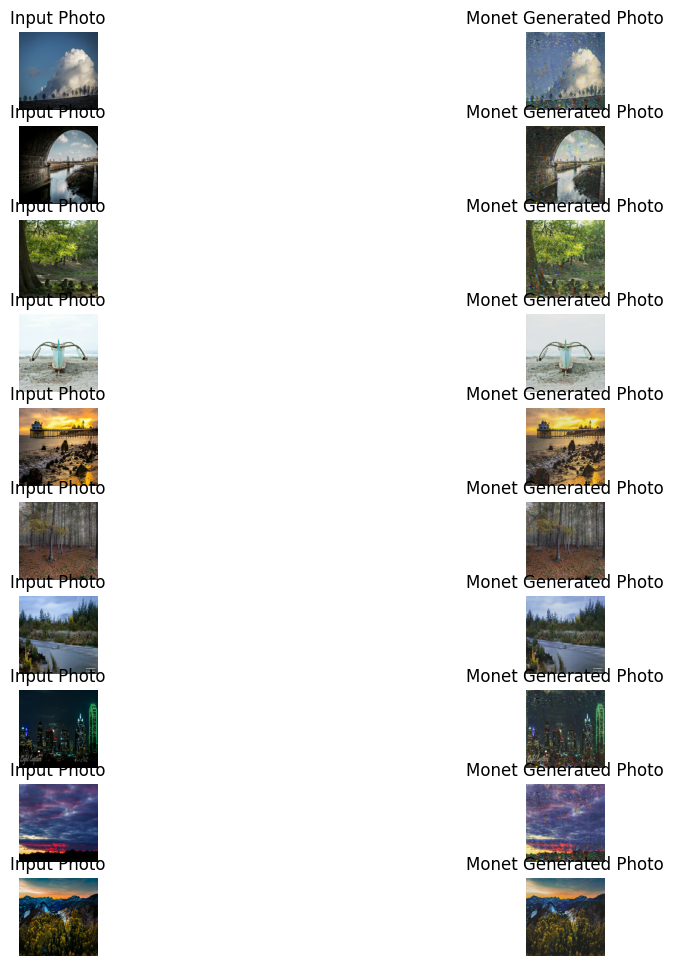

In [18]:
_, ax = plt.subplots(10, 2, figsize=(12, 12))
for i, image in enumerate(photo_datasets.take(10)):
    prediction = Monet_gen(image, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    image = (image[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(image)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet Generated Photo")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [19]:
#Submission File
import PIL
! mkdir ../images

In [22]:
i = 1
for img in photo_datasets:
    prediction = Monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [23]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

# Resources

GANs Medium - https://jonathan-hui.medium.com/gan-gan-series-2d279f906e7b
Tensorflow CycleGan - https://www.tensorflow.org/tutorials/generative/cyclegan
CycleGAN Implementation and Code snippets Source - kaggle.com/code/amyjang/monet-cyclegan-tutorial



### Readings
- Orginial GAN paper - https://arxiv.org/pdf/1406.2661.pdf
- Unsupervised Representation Learning with Deep Convolutional NN - https://arxiv.org/pdf/1511.06434.pdf
- GAN tutorial (Ian Goodfellow) - https://arxiv.org/pdf/1701.00160.pdf
- ConditionalGAN - https://arxiv.org/pdf/1411.1784.pdf
- Hyperparameter Tuning GAN - https://arxiv.org/pdf/1606.03498.pdf